# Load and Visualize IBM Debater® Sentiment Composition Lexicons

In this notebook you will load, explore, clean and visualize data from the IBM Debater Sentiment Composition Lexicons dataset. The dataset includes sentiment composition lexicons and sentiment lexicons:
1. Sentiment composition lexicons containing 2,783 words.
2. Sentiment lexicons containing 66,058 unigrams and 262,555 bigrams.

The dataset addresses sentiment composition – predicting the sentiment of a phrase from the interaction between its constituents. For example, in the phrases “reduced bureaucracy” and “fresh injury”, both “reduced” and “fresh” are followed by a negative word. However, “reduced” flips the negative polarity, resulting in a positive phrase, while “fresh” propagates the negative polarity to the phrase level, resulting in a negative phrase. Accordingly, “reduced” is part of our “reversers” lexicon, and “fresh” is part of the “propagators” lexicon.

The dataset can be obtained for free from <a href="https://developer.ibm.com/exchanges/data/all/sentiment-composition-lexicons/" target="_blank" rel="noopener noreferrer">IBM Developer Data Asset Exchange</a>.

### Table of Contents

* [0. Prerequisite](#prerequisite)
* [1. Load Data](#load)   
    * [1.1 About](#abstract)
    * [1.2 Read Data](#read)
* [2. Data Visualization](#visualize)
    * [2.1 Unigram](#2-1)
    * [2.2 Bigram](#2-2)
* [3. Save the Cleaned Data](#save)
* [Authors](#authors)




<a class="anchor" id="prerequisite"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Import required modules

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html" target="_blank" rel="noopener noreferrer">these instructions</a>.

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required modules

Import and configure the required modules.

In [2]:
# Define required imports
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
!pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import clear_output
clear_output()

## 1. Load Data <a class="anchor" id="load"></a>
### 1.1 About <a class="anchor" id="abstract"></a>

The goal of this set of notebooks is to use the <a href="https://developer.ibm.com/exchanges/data/all/sentiment-composition-lexicons/" target="_blank" rel="noopener noreferrer">IBM Debater Sentiment Composition Lexicons</a> dataset to categorize text on a sentence level, or as a whole, with a range of sentiments. This could be used in an application which collects customer feedback to help determine customer satisfaction.

Let's first explain a few definitions:

- **Sentiment Analysis**: Using natural language processing to determine the sentiment of a piece of text, e.g. determine if the text has a positive, negative, or neutral connotation. 

- **N-gram**: a sequence of N terms

- **Unigram**: an N-gram with one term, e.g. “hello”

- **Bi-gram**: an N-gram with two terms, e.g. “hello world”

- **POS (part of speech) tag**: a word's part of speech, e.g. the POS tag for "dog" would be noun (or NN in the NLTK Python library).

### 1.2 Read Data <a class="anchor" id="read"></a>

The first step is to load, and then modify the LEXICON_UG.txt and LEXICON_BG.txt datasets to include a sentiment column that is based on the SENTIMENT_SCORE column, but uses 1 or 0, where 1 is positive sentiment and 0 is negative sentiment.

In [3]:
# Define get data file function
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

#### LEXICON_UG.txt: 
This is a list of 66,058 unigrams and their predicted sentiment score. Note that in the paper <a href="https://www.aclweb.org/anthology/C18-1189.pdf" target="_blank" rel="noopener noreferrer">Learning Sentiment Composition from Sentiment Lexicons</a>, for unigrams that have sentiment in the HL lexicon (the publicly-available sentiment lexicon of Hu and Liu (2004)), the original sentiment from the HL lexicon (+1 or -1) was used, and not the predicted score. This step is not reflected in the released lexicon. 

In [4]:
# define filename
DATA_PATH = 'LEXICON_UG.txt'

# Using pandas to read the data 
data_path = get_file_handle(DATA_PATH)
unigrams = pd.read_csv(data_path, sep=" ")
unigrams.head()

UNIGRAM  SENTIMENT_SCORE
0      aa         0.019674
1     aaa         0.032775
2    aaas         0.074593
3  aachen         0.011926
4     aah         0.118070

#### LEXICON_BG.txt: 
This is a list of 262,555 selected bigrams in the following format:
- Column 1: the bigram
- Column 2: the OpenNLP POS tags of its unigrams
- Column 3: the predicted sentiment score

In [5]:
# define filename
DATA_PATH = 'LEXICON_BG.txt'

# Using pandas to read the data 
data_path = get_file_handle(DATA_PATH)
bigrams = pd.read_csv(data_path, sep=" ")
bigrams.head()

BIGRAM POS_TAGS  SENTIMENT_SCORE
0       abalone-divers   NN-NNS        -0.090230
1    abandoned-animals  VBN-NNS        -0.089895
2  abandoned-apartment   VBN-NN        -0.126907
3   abandoned-attempts  VBN-NNS        -0.053709
4     abandoned-babies  VBN-NNS        -0.074742

### 2. Data Visualization <a class="anchor" id="visualize"></a>

In this section, we will visualize the unigrams and bigrams datasets.

#### 2.1 Unigrams <a class="anchor" id="2-1"></a>

First, let's categorize the sentiment of each term.

In [6]:
# Add sentiment column
unigrams['sentiment'] = np.where(unigrams['SENTIMENT_SCORE'] > 0, 1, 0)  # 1 is positive, 0 is negative
unigrams.head()

UNIGRAM  SENTIMENT_SCORE  sentiment
0      aa         0.019674          1
1     aaa         0.032775          1
2    aaas         0.074593          1
3  aachen         0.011926          1
4     aah         0.118070          1

We want to check the distribution of the review sentiment polarity score.

In [7]:
# The distribution of review sentiment polarity score
unigrams['SENTIMENT_SCORE'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')
# The sentiment polarity score is similar to a bell curve, center at 0, means half of them are positive, half are negative.

The distribution of sentiment polarity is a bell-shaped curve.

Then, let's check the unigram text length distribution.

In [8]:
# Get the string length of each unigram word
unigrams['uni_len'] = [len(str(i)) for i in unigrams['UNIGRAM']]
# Plot the unigram length distribution
unigrams['uni_len'].iplot(
    kind='hist',
    xTitle='unigram length',
    linecolor='black',
    yTitle='count',
    title='Unigram Text Length Distribution')

The distribution of unigram text length is also approximately normally distributed, which means our dataset is balanced.

We are now saving the first letter of each term.

In [9]:
unigrams['first_letter'] = unigrams.UNIGRAM.str[0]
unigrams.head()

UNIGRAM  SENTIMENT_SCORE  sentiment  uni_len first_letter
0      aa         0.019674          1        2            a
1     aaa         0.032775          1        3            a
2    aaas         0.074593          1        4            a
3  aachen         0.011926          1        6            a
4     aah         0.118070          1        3            a

In these mext steps, we group by the first letter and sentiment score of each term, and then count amount of unigrams under each category.

In [10]:
# get number of words under each alphabet
group_data = unigrams.groupby(['first_letter', 'sentiment'])
group_data.count()

UNIGRAM  SENTIMENT_SCORE  uni_len
first_letter sentiment                                   
a            0             2022             2022     2022
             1             2041             2041     2041
b            0             2569             2569     2569
             1             1409             1409     1409
c            0             3595             3595     3595
             1             2787             2787     2787
d            0             2645             2645     2645
             1             1261             1261     1261
e            0             1293             1293     1293
             1             1413             1413     1413
f            0             1637             1637     1637
             1             1062             1062     1062
g            0             1242             1242     1242
             1              973              973      973
h            0             1531             1531     1531
             1              995              995      995
i            0             1594             1594     1594
             1             1013             1013     1013
j            0              400              400      400
             1              230              230      230
k            0              435              435      435
             1              301              301      301
l            0             1280             1280     1280
             1              931              931      931
m            0             2205             2205     2205
             1             1493             1493     1493
n            0              810              810      810
             1              592              592      592
o            0              962              962      962
             1              628              628      628
p            0             3001             3001     3001
             1             2094             2094     2094
q            0              168              168      168
             1              130              130      130
r            0             2023             2023     2023
             1             1730             1730     1730
s            0             4768             4768     4768
             1             2714             2714     2714
t            0             2035             2035     2035
             1             1351             1351     1351
u            0             1121             1121     1121
             1              446              446      446
v            0              539              539      539
             1              471              471      471
w            0             1123             1123     1123
             1              552              552      552
x            0               28               28       28
             1               28               28       28
y            0              116              116      116
             1               91               91       91
z            0              117              117      117
             1               61               61       61

Now, we visualize the distribution of the unigram count of all letters.

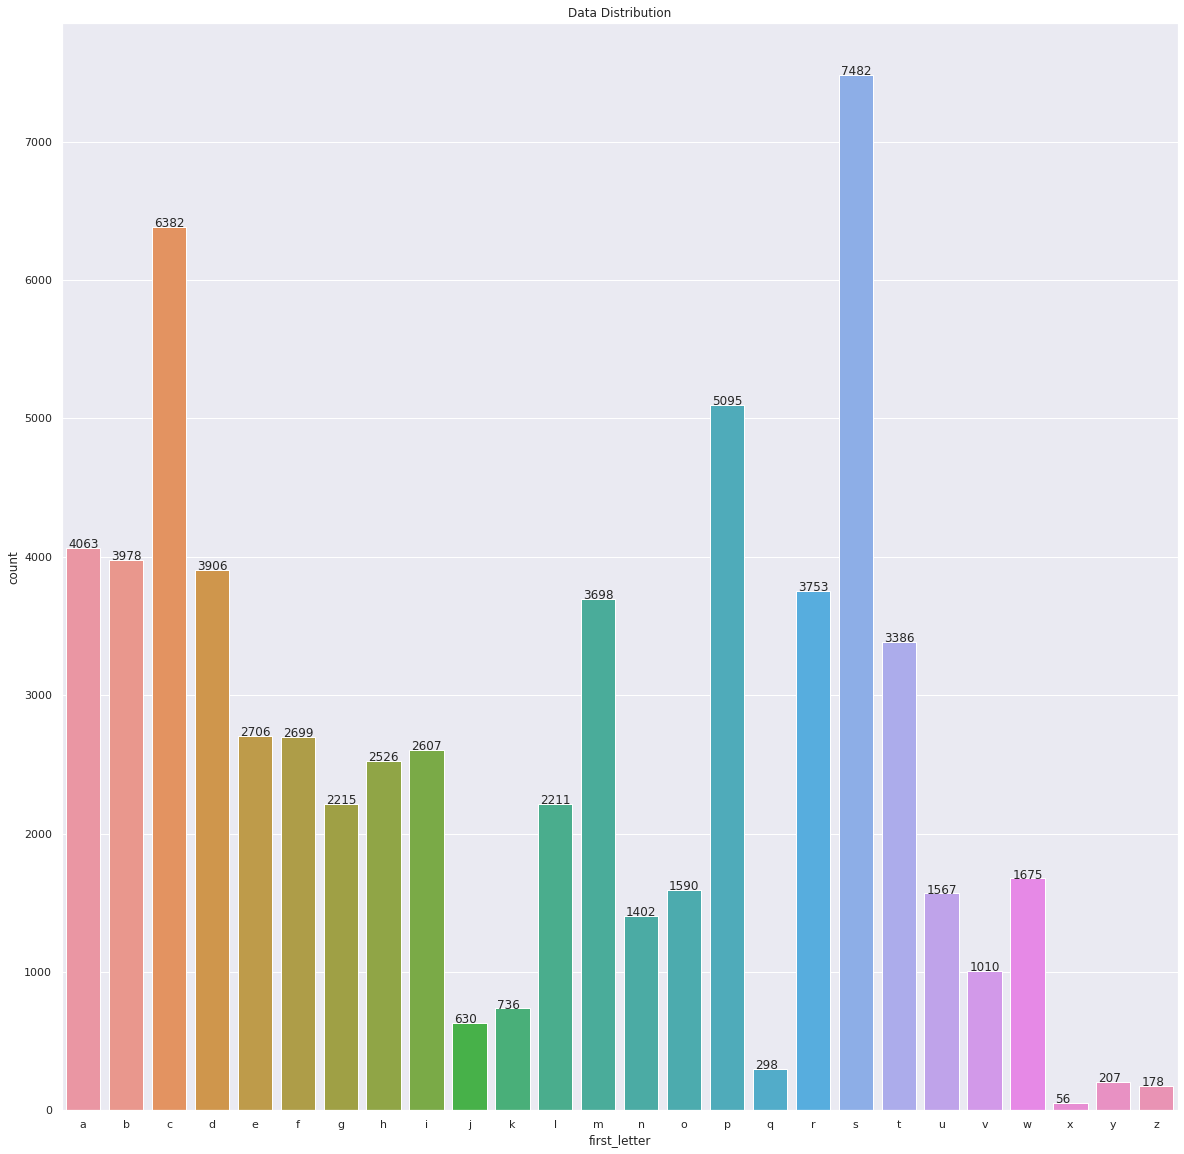

In [11]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="first_letter", data=unigrams)

plt.title('Data Distribution')

for p in ax.patches:
        total_count = str(p.get_height())
        x=p.get_x() + p.get_width() - 0.75
        y=p.get_y() +p.get_height()
        ax.annotate(total_count, (x, y))

In the unigrams dataset, the first letter normally starts with s or c while the least frequent letters are x, y, and z.

#### 2.2 Bigrams <a class="anchor" id="2-2"></a>

Similarly, we categorize the sentiment of each term, positive or negative.

In [12]:
# Add sentiment column
bigrams['sentiment'] = np.where(bigrams['SENTIMENT_SCORE'] > 0, 1, 0)  # 1 is positive, 0 is negative
bigrams.head()

BIGRAM POS_TAGS  SENTIMENT_SCORE  sentiment
0       abalone-divers   NN-NNS        -0.090230          0
1    abandoned-animals  VBN-NNS        -0.089895          0
2  abandoned-apartment   VBN-NN        -0.126907          0
3   abandoned-attempts  VBN-NNS        -0.053709          0
4     abandoned-babies  VBN-NNS        -0.074742          0

And then we visualize the sentiment polarity distribution.

In [13]:
# The distribution of review sentiment polarity score
bigrams['SENTIMENT_SCORE'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

We group by the POS-TAGS and sentiment score of each bigram term.

In [14]:
df = pd.DataFrame(bigrams.groupby(['POS_TAGS', 'sentiment']).size().reset_index())
df.head()

POS_TAGS  sentiment     0
0    JJ-JJ          0  1698
1    JJ-JJ          1  2000
2   JJ-JJR          0     5
3   JJ-JJR          1     3
4   JJ-JJS          0     9

Visualize the histograms of pos-tags and show the count of positive versus negative sentiment.

In [15]:
import plotly.express as px

fig = px.bar(df, x="POS_TAGS", y=0, color="sentiment", title="Long-Form Input")
fig.show()

In [16]:
bigrams.groupby('POS_TAGS').count()['SENTIMENT_SCORE'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Pos Tags Count', xTitle='Pos Tag')

In [17]:
# get number of words under each POS Tag
group_data = bigrams.groupby(['POS_TAGS','sentiment'])
group_data.count()

BIGRAM  SENTIMENT_SCORE
POS_TAGS sentiment                         
JJ-JJ    0            1698             1698
         1            2000             2000
JJ-JJR   0               5                5
         1               3                3
JJ-JJS   0               9                9
...                    ...              ...
VBP-NNS  1             151              151
VBZ-NN   0             326              326
         1             609              609
VBZ-NNS  0             179              179
         1             743              743

[91 rows x 2 columns]

In [18]:
# add first letter and sentiment columns
bigrams['first_letter'] = bigrams.BIGRAM.str[0]
# get number of words under each alphabet
group_data = bigrams.groupby(['first_letter','sentiment'])
group_data.count()

BIGRAM  POS_TAGS  SENTIMENT_SCORE
first_letter sentiment                                   
a            0            6784      6784             6784
             1            7192      7192             7192
b            0            7012      7012             7012
             1            5127      5127             5127
c            0           12077     12077            12077
             1           11856     11856            11856
d            0            9196      9196             9196
             1            6117      6117             6117
e            0            6377      6377             6377
             1            9498      9498             9498
f            0            7880      7880             7880
             1            5584      5584             5584
g            0            3486      3486             3486
             1            4278      4278             4278
h            0            4982      4982             4982
             1            3664      3664             3664
i            0            6628      6628             6628
             1            6920      6920             6920
j            0             673       673              673
             1             349       349              349
k            0             532       532              532
             1             486       486              486
l            0            5206      5206             5206
             1            4531      4531             4531
m            0            7747      7747             7747
             1            6936      6936             6936
n            0            2711      2711             2711
             1            2348      2348             2348
o            0            3872      3872             3872
             1            3459      3459             3459
p            0           11531     11531            11531
             1            9215      9215             9215
q            0             486       486              486
             1             654       654              654
r            0            7508      7508             7508
             1            7032      7032             7032
s            0           16508     16508            16508
             1           13062     13062            13062
t            0            6951      6951             6951
             1            5667      5667             5667
u            0            5066      5066             5066
             1            2353      2353             2353
v            0            2427      2427             2427
             1            2606      2606             2606
w            0            4293      4293             4293
             1            2677      2677             2677
x            0               7         7                7
             1               6         6                6
y            0             268       268              268
             1             620       620              620
z            0              87        87               87
             1              23        23               23

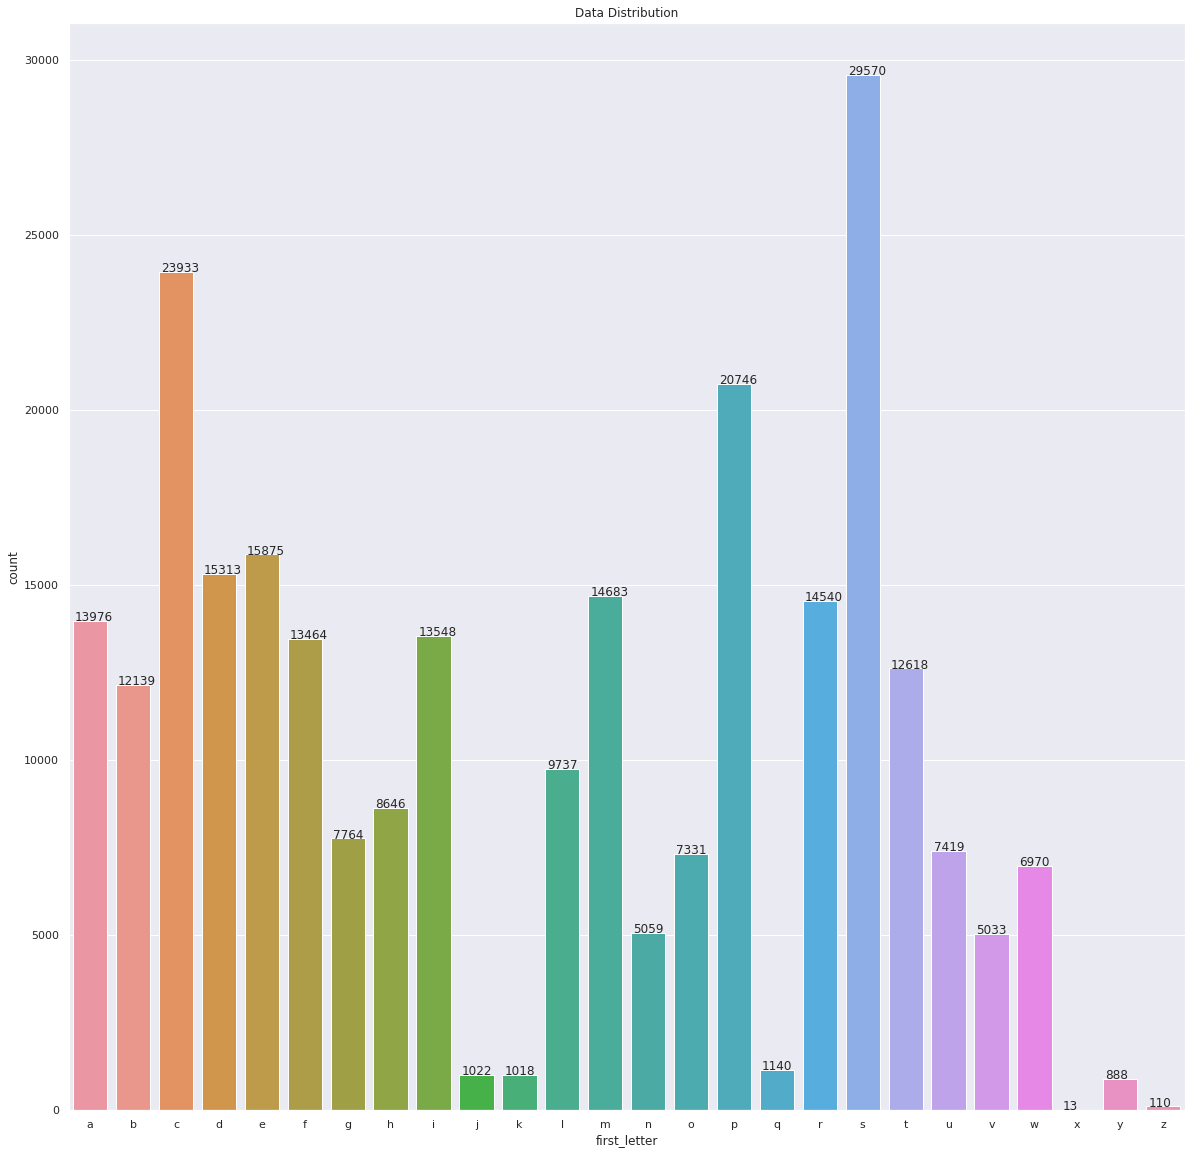

In [19]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="first_letter", data=bigrams)

plt.title('Data Distribution')

for p in ax.patches:
        total_count = str(p.get_height())
        x=p.get_x() + p.get_width() - 0.75
        y=p.get_y() +p.get_height()
        ax.annotate(total_count, (x, y))

### 3. Save the Cleaned Data <a id="save"></a> 

Finally, we save the cleaned dataset as a Project asset for later re-use. You should see similar to the following after saving the file:

```
{'file_name': 'bigrams.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdebatersentimentcompositionlex-...',
 'asset_id': '...'}
```

**Note**: In order for this step to work, your project token (see the first cell of this notebook) must have `Editor` role. By default this will overwrite any existing file.

In [ ]:
project.save_data("unigrams.csv", unigrams.to_csv(float_format='%g'), overwrite=True)
project.save_data("bigrams.csv", bigrams.to_csv(float_format='%g'), overwrite=True)

#### Next steps

- Close this notebook.
- Open the `Part 2 - Model Development` notebook to explore the cleaned dataset.

### Citation
Toledo-Ronen et. al, <i>Learning Sentiment Composition from Sentiment Lexicons</i>, COLING 2018


<a id="authors"></a> 
### Authors
This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

<hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.